# Deep Learning - Assignment 3 - Problem 1
### Ali Abbasi - 98105879

In [ ]:
!git clone https://github.com/a80-abbasi/DeepLearningAssignments.git
%cd "./DeepLearningAssignments/Assignment 3"
!unzip archive.zip

# Importing Libraries

In [2]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

import tqdm
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [8]:
torch.manual_seed(24)
np.random.seed(24)

# Datasets and Dataloaders

In [3]:
import bisect

class Footwear(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transform=None, shuffle=True):
        self.transform = transform
        self.target_names = os.listdir(dataset_path)
        self.name_to_label = {name: i for i, name in enumerate(self.target_names)}
        self.label_to_name = {i: name for name, i in self.name_to_label.items()}
        self.files = []
        self.labels = []
        for label, name in enumerate(self.target_names):
            for file in os.listdir(os.path.join(dataset_path, name)):
                self.files.append(os.path.join(dataset_path, name, file))
                self.labels.append(label)
        self.files = np.array(self.files)
        self.labels = np.array(self.labels)
        if shuffle:
            idx = np.random.permutation(len(self.files))
            self.files = self.files[idx]
            self.labels = self.labels[idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        assert item < self.__len__(), f"Index {item} is out of range"
        file = self.files[item]
        label = self.labels[item]
        imgage = Image.open(file)
        if self.transform is not None:
            imgage = self.transform(imgage)
        return imgage, label


In [10]:
dataset = Footwear("Shoe vs Sandal vs Boot Dataset", transform=T.Compose([T.ToTensor()]))

shapes = set()
for i in range(len(dataset)):
  x, y = dataset[i]
  shapes.add(x.shape)

print(shapes)

{torch.Size([3, 102, 135]), torch.Size([3, 102, 136])}


In [4]:
dataset = Footwear("Shoe vs Sandal vs Boot Dataset", transform=T.Compose([T.ToTensor(), T.Resize((50, 65))]))

test_size = int(len(dataset) * 0.3)
train_size = len(dataset) - test_size
val_size = int(train_size * 0.2)
train_size = train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [5]:
train_size, val_size, test_size

(8400, 2100, 4500)

In [6]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(dataset.target_names)
image_shape

torch.Size([3, 50, 65])

In [14]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)
val_loader = DataLoader(val_set, 64, shuffle=True)

## Visualization

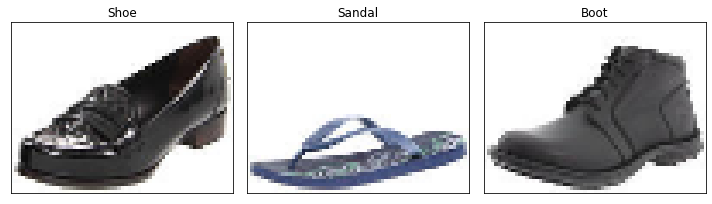

In [15]:
fig, axes = plt.subplots(1,3, figsize=(10, 10))
axes = axes.flat
topil = T.ToPILImage()
for j in range(len(dataset.target_names)):
    i = np.random.choice(np.where(np.array(dataset.labels) == j)[0])
    x, y = dataset[i]
    ax = axes[j]
    img = topil(x)
    ax.imshow(img)
    ax.set_title(dataset.label_to_name[y])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# MLP Model

In [16]:
from more_itertools import pairwise

class MLP_Model(nn.Module):
    
    def __init__(self, layers_inputs, dropout=False):
        super().__init__()
        layers_shape = list(pairwise(layers_inputs))
        layers = []
        for shape in layers_shape[:-1]:
            layers.append(nn.Linear(*shape))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(*layers_shape[-1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

In [17]:
layers_inputs = [input_dim, 256, 128, 64, num_classes]
model = MLP_Model(layers_inputs, dropout=0.4)
model

MLP_Model(
  (layers): Sequential(
    (0): Linear(in_features=9750, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=64, out_features=3, bias=True)
  )
)

# Training Model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [20]:
def one_epoch(model, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
        for i, (x, y) in pbar:
            if train:
                optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y.long())

            total_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')
            if train:
                loss.backward()
                optimizer.step()

            y_pred = p.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [22]:
from torch.utils.tensorboard import SummaryWriter

In [23]:
def train_model(model, dataloaders, num_epochs, criterion, optimizer, model_name='pytroch-model', tensorboard_writer=None):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    for epoch in range(num_epochs):
        result = one_epoch(model, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(model, val_loader, criterion, epoch=epoch, train=False, set_name='Validation')
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print('\n', '-' * 60)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
        if tensorboard_writer:
            tensorboard_writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
            tensorboard_writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)

    tensorboard_writer.close()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('loss history of training and val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and val sets')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(f'{model_name}.pt'))
    return model, min_val_loss

### Training:

0: Train Loss: 8.291e-01: : 132it [00:07, 17.06it/s]


Accuracy of Train set: 0.5791666666666667


0: Validation Loss: 5.622e-01: : 33it [00:01, 22.28it/s]


Accuracy of Validation set: 0.7471428571428571

 ------------------------------------------------------------


1: Train Loss: 6.300e-01: : 132it [00:06, 20.52it/s]


Accuracy of Train set: 0.7164285714285714


1: Validation Loss: 4.587e-01: : 33it [00:01, 22.73it/s]


Accuracy of Validation set: 0.8152380952380952

 ------------------------------------------------------------


2: Train Loss: 5.978e-01: : 132it [00:06, 20.61it/s]


Accuracy of Train set: 0.7388095238095238


2: Validation Loss: 4.187e-01: : 33it [00:01, 22.30it/s]


Accuracy of Validation set: 0.8552380952380952

 ------------------------------------------------------------


3: Train Loss: 6.001e-01: : 132it [00:06, 20.92it/s]


Accuracy of Train set: 0.7347619047619047


3: Validation Loss: 4.270e-01: : 33it [00:01, 22.85it/s]


Accuracy of Validation set: 0.8585714285714285

 ------------------------------------------------------------


4: Train Loss: 5.685e-01: : 132it [00:06, 20.65it/s]


Accuracy of Train set: 0.7648809523809523


4: Validation Loss: 4.269e-01: : 33it [00:01, 22.62it/s]


Accuracy of Validation set: 0.8242857142857143

 ------------------------------------------------------------


5: Train Loss: 5.410e-01: : 132it [00:06, 20.90it/s]


Accuracy of Train set: 0.7777380952380952


5: Validation Loss: 4.376e-01: : 33it [00:01, 22.43it/s]


Accuracy of Validation set: 0.8542857142857143

 ------------------------------------------------------------


6: Train Loss: 5.508e-01: : 132it [00:06, 20.62it/s]


Accuracy of Train set: 0.7642857142857142


6: Validation Loss: 3.707e-01: : 33it [00:01, 22.10it/s]


Accuracy of Validation set: 0.8733333333333333

 ------------------------------------------------------------


7: Train Loss: 5.740e-01: : 132it [00:06, 20.90it/s]


Accuracy of Train set: 0.7359523809523809


7: Validation Loss: 5.042e-01: : 33it [00:01, 22.57it/s]


Accuracy of Validation set: 0.8247619047619048

 ------------------------------------------------------------


8: Train Loss: 5.493e-01: : 132it [00:07, 17.67it/s]


Accuracy of Train set: 0.7728571428571429


8: Validation Loss: 3.698e-01: : 33it [00:01, 22.37it/s]


Accuracy of Validation set: 0.8866666666666667

 ------------------------------------------------------------


9: Train Loss: 5.707e-01: : 132it [00:06, 20.96it/s]


Accuracy of Train set: 0.7590476190476191


9: Validation Loss: 3.878e-01: : 33it [00:01, 22.40it/s]


Accuracy of Validation set: 0.8576190476190476

 ------------------------------------------------------------


10: Train Loss: 5.743e-01: : 132it [00:06, 20.81it/s]


Accuracy of Train set: 0.7578571428571429


10: Validation Loss: 3.975e-01: : 33it [00:01, 22.33it/s]


Accuracy of Validation set: 0.8823809523809524

 ------------------------------------------------------------


11: Train Loss: 5.476e-01: : 132it [00:06, 21.09it/s]


Accuracy of Train set: 0.763452380952381


11: Validation Loss: 3.606e-01: : 33it [00:01, 22.77it/s]


Accuracy of Validation set: 0.8909523809523809

 ------------------------------------------------------------


12: Train Loss: 5.806e-01: : 132it [00:06, 20.76it/s]


Accuracy of Train set: 0.75


12: Validation Loss: 3.781e-01: : 33it [00:01, 16.86it/s]


Accuracy of Validation set: 0.89

 ------------------------------------------------------------


13: Train Loss: 5.431e-01: : 132it [00:13, 10.06it/s]


Accuracy of Train set: 0.7671428571428571


13: Validation Loss: 4.085e-01: : 33it [00:03, 10.55it/s]


Accuracy of Validation set: 0.8766666666666667

 ------------------------------------------------------------


14: Train Loss: 5.374e-01: : 132it [00:06, 19.10it/s]


Accuracy of Train set: 0.7776190476190477


14: Validation Loss: 3.222e-01: : 33it [00:01, 22.44it/s]


Accuracy of Validation set: 0.8933333333333333

 ------------------------------------------------------------


15: Train Loss: 5.243e-01: : 132it [00:06, 20.66it/s]


Accuracy of Train set: 0.7822619047619047


15: Validation Loss: 4.678e-01: : 33it [00:01, 21.83it/s]


Accuracy of Validation set: 0.871904761904762

 ------------------------------------------------------------


16: Train Loss: 5.472e-01: : 132it [00:06, 20.79it/s]


Accuracy of Train set: 0.7676190476190476


16: Validation Loss: 3.725e-01: : 33it [00:01, 21.82it/s]


Accuracy of Validation set: 0.8714285714285714

 ------------------------------------------------------------


17: Train Loss: 5.366e-01: : 132it [00:06, 20.98it/s]


Accuracy of Train set: 0.7703571428571429


17: Validation Loss: 4.120e-01: : 33it [00:01, 22.76it/s]


Accuracy of Validation set: 0.8819047619047619

 ------------------------------------------------------------


18: Train Loss: 5.127e-01: : 132it [00:06, 21.02it/s]


Accuracy of Train set: 0.7822619047619047


18: Validation Loss: 3.810e-01: : 33it [00:01, 22.38it/s]


Accuracy of Validation set: 0.8904761904761904

 ------------------------------------------------------------


19: Train Loss: 5.180e-01: : 132it [00:06, 20.92it/s]


Accuracy of Train set: 0.7822619047619047


19: Validation Loss: 3.470e-01: : 33it [00:01, 22.37it/s]


Accuracy of Validation set: 0.8938095238095238

 ------------------------------------------------------------


20: Train Loss: 5.137e-01: : 132it [00:06, 20.80it/s]


Accuracy of Train set: 0.7880952380952381


20: Validation Loss: 3.854e-01: : 33it [00:01, 22.11it/s]


Accuracy of Validation set: 0.8933333333333333

 ------------------------------------------------------------


21: Train Loss: 5.044e-01: : 132it [00:06, 20.58it/s]


Accuracy of Train set: 0.7884523809523809


21: Validation Loss: 4.339e-01: : 33it [00:01, 22.59it/s]


Accuracy of Validation set: 0.8538095238095238

 ------------------------------------------------------------


22: Train Loss: 4.982e-01: : 132it [00:07, 17.74it/s]


Accuracy of Train set: 0.795


22: Validation Loss: 3.291e-01: : 33it [00:01, 22.35it/s]


Accuracy of Validation set: 0.8861904761904762

 ------------------------------------------------------------


23: Train Loss: 4.687e-01: : 132it [00:06, 20.33it/s]


Accuracy of Train set: 0.8147619047619048


23: Validation Loss: 3.667e-01: : 33it [00:01, 22.22it/s]


Accuracy of Validation set: 0.8842857142857142

 ------------------------------------------------------------


24: Train Loss: 4.737e-01: : 132it [00:06, 20.75it/s]


Accuracy of Train set: 0.8054761904761905


24: Validation Loss: 3.677e-01: : 33it [00:01, 22.32it/s]


Accuracy of Validation set: 0.8828571428571429

 ------------------------------------------------------------


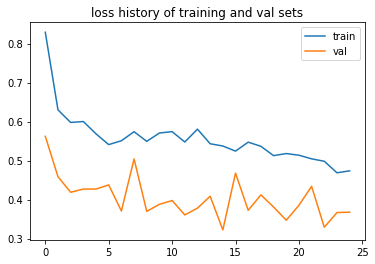

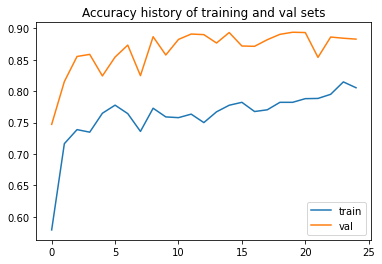

In [24]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
model = MLP_Model(layers_inputs, dropout=0.4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/MLP')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

### MLP Results

In [27]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

: Test Loss: 3.401e-01: : 71it [00:04, 16.06it/s]


Accuracy of Test set: 0.8835555555555555


{'loss': 0.340121816555659,
 'accuracy': 0.8835555555555555,
 'precision': 0.8844216235971688,
 'recall': 0.8832504405406215,
 'f1': 0.8827702995055021}

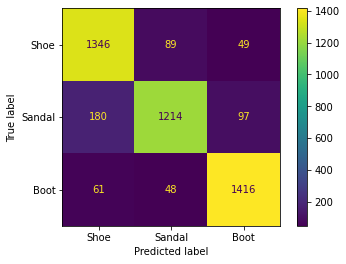

In [29]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.target_names)
disp.plot()
test_results

: Validation Loss: 3.222e-01: : 33it [00:01, 22.04it/s]


Accuracy of Validation set: 0.8933333333333333


{'loss': 0.3221804814111619,
 'accuracy': 0.8933333333333333,
 'precision': 0.8934669518436013,
 'recall': 0.8924469121908495,
 'f1': 0.8925359692971716}

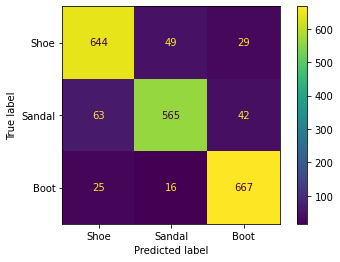

In [30]:
val_results = one_epoch(model, val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=dataset.target_names)
disp.plot()
val_results

: Train Loss: 3.120e-01: : 132it [00:06, 21.67it/s]

Accuracy of Train set: 0.8933333333333333


{'loss': 0.31202149186815537,
 'accuracy': 0.8933333333333333,
 'precision': 0.8944053003134093,
 'recall': 0.8937800244299602,
 'f1': 0.8933284125754123}

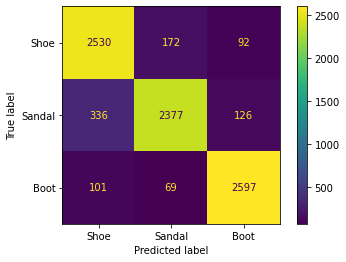

In [31]:
train_results = one_epoch(model, train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=dataset.target_names)
disp.plot()
train_results

### MLP Number of Parameters

In [32]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 2537603


### Tensorboard Results
Now we can see the tensorboard results for this part by running the command `tensorboard --logdir=runs/MLP` in the terminal. Since it opens in a tab, we can see the results in the following image:

![MLP-tensorboard](Images/MLP-tensorboard.png)

# Convolutional Model

In [7]:
class DropBlock2D(nn.Module):
    def __init__(self, block_size, drop_rate, batchwise=True):
        super(DropBlock2D, self).__init__()
        self.block_size = block_size
        self.droprate = drop_rate
        self.batchwise = batchwise
        self.gamma = None
        self.bernoulli = None

    def forward(self, x):
        if not self.training or self.droprate == 0:
            return x

        if self.gamma is None or self.bernoulli is None:
            self._create_params(x)

        if self.batchwise:
            mask = self.bernoulli.sample((1, *x.size()[1:])).to(x.device)
        else:
            mask = self.bernoulli.sample(x.size()).to(x.device)
        
        mask = F.max_pool2d(mask, self.block_size, stride=1, padding=self.block_size // 2)
        if self.block_size % 2 == 0:
            mask = mask[:, :, :-1, :-1]
        mask = 1 - mask

        normalize_scale = (mask.numel() / mask.float().sum().add(1e-6)).to(dtype=x.dtype)
        out = x * mask * normalize_scale
        return out

    def _create_params(self, x):
        gamma = self.droprate / (self.block_size ** 2)
        bernoulli = torch.distributions.bernoulli.Bernoulli(gamma)

        self.gamma = gamma
        self.bernoulli = bernoulli

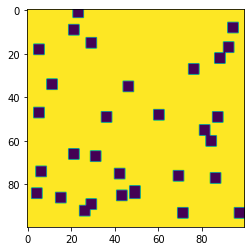

In [61]:
plt.imshow(DropBlock2D(5, 0.1)(torch.ones(1, 1, 100, 100)).squeeze().detach().numpy())
plt.show()

In [8]:
class Conv_Model(nn.Module):
    
    def __init__(self, input_shape, conv_layers, dropout_type=None, dropout_rate=None, batch_norm=False, kernel_factorization=False):
        super().__init__()
        layers = []
        for conv in conv_layers:
            if conv[0] == 'pool':
                layers.append(nn.MaxPool2d(conv[1:]))
                continue
            if kernel_factorization:
                conv_1 = [*conv]
                conv_1[2] = (1, conv_1[2])
                layers.append(nn.Conv2d(*conv_1))
                conv_2 = [*conv]
                conv_2[2] = (conv_2[2], 1)
                conv_2[0] = conv_1[1]
                layers.append(nn.Conv2d(*conv_2))
            else:
                layers.append(nn.Conv2d(*conv))
            if batch_norm:
                layers.append(nn.BatchNorm2d(conv[1]))
            layers.append(nn.ReLU())
            if dropout_type == 'block':
                layers.append(DropBlock2D(5, dropout_rate))
            elif dropout_type == 'dropout':
                layers.append(nn.Dropout(dropout_rate))
        self.convs = nn.Sequential(*layers)
        with torch.no_grad():
            conv_output_shape = self.convs(torch.zeros(1, *input_shape)).shape[1:]
        self.classifier = nn.Linear(np.prod(conv_output_shape), num_classes)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

### Training Convolutional Model:

0: Train Loss: 6.340e-01: : 132it [00:06, 19.23it/s]


Accuracy of Train set: 0.7107142857142857


0: Validation Loss: 3.842e-01: : 33it [00:01, 21.85it/s]


Accuracy of Validation set: 0.8566666666666667

 ------------------------------------------------------------


1: Train Loss: 3.929e-01: : 132it [00:06, 19.36it/s]


Accuracy of Train set: 0.8433333333333334


1: Validation Loss: 2.764e-01: : 33it [00:01, 22.62it/s]


Accuracy of Validation set: 0.9052380952380953

 ------------------------------------------------------------


2: Train Loss: 2.928e-01: : 132it [00:06, 19.47it/s]


Accuracy of Train set: 0.8902380952380953


2: Validation Loss: 2.448e-01: : 33it [00:01, 22.06it/s]


Accuracy of Validation set: 0.9071428571428571

 ------------------------------------------------------------


3: Train Loss: 2.474e-01: : 132it [00:06, 19.51it/s]


Accuracy of Train set: 0.9067857142857143


3: Validation Loss: 2.167e-01: : 33it [00:01, 22.35it/s]


Accuracy of Validation set: 0.9266666666666666

 ------------------------------------------------------------


4: Train Loss: 2.255e-01: : 132it [00:06, 19.45it/s]


Accuracy of Train set: 0.915952380952381


4: Validation Loss: 1.919e-01: : 33it [00:01, 22.09it/s]


Accuracy of Validation set: 0.9333333333333333

 ------------------------------------------------------------


5: Train Loss: 2.008e-01: : 132it [00:06, 18.99it/s]


Accuracy of Train set: 0.9286904761904762


5: Validation Loss: 1.705e-01: : 33it [00:01, 21.86it/s]


Accuracy of Validation set: 0.9357142857142857

 ------------------------------------------------------------


6: Train Loss: 1.852e-01: : 132it [00:06, 18.87it/s]


Accuracy of Train set: 0.9342857142857143


6: Validation Loss: 1.671e-01: : 33it [00:01, 21.52it/s]


Accuracy of Validation set: 0.9414285714285714

 ------------------------------------------------------------


7: Train Loss: 1.814e-01: : 132it [00:08, 16.13it/s]


Accuracy of Train set: 0.9370238095238095


7: Validation Loss: 1.676e-01: : 33it [00:01, 22.17it/s]


Accuracy of Validation set: 0.9476190476190476

 ------------------------------------------------------------


8: Train Loss: 1.674e-01: : 132it [00:06, 18.94it/s]


Accuracy of Train set: 0.9396428571428571


8: Validation Loss: 1.442e-01: : 33it [00:01, 21.43it/s]


Accuracy of Validation set: 0.95

 ------------------------------------------------------------


9: Train Loss: 1.664e-01: : 132it [00:07, 18.58it/s]


Accuracy of Train set: 0.9386904761904762


9: Validation Loss: 1.566e-01: : 33it [00:01, 21.68it/s]


Accuracy of Validation set: 0.9442857142857143

 ------------------------------------------------------------


10: Train Loss: 1.605e-01: : 132it [00:06, 19.12it/s]


Accuracy of Train set: 0.9402380952380952


10: Validation Loss: 1.460e-01: : 33it [00:01, 21.95it/s]


Accuracy of Validation set: 0.9495238095238095

 ------------------------------------------------------------


11: Train Loss: 1.527e-01: : 132it [00:06, 19.05it/s]


Accuracy of Train set: 0.944047619047619


11: Validation Loss: 1.370e-01: : 33it [00:01, 21.66it/s]


Accuracy of Validation set: 0.9533333333333334

 ------------------------------------------------------------


12: Train Loss: 1.372e-01: : 132it [00:07, 18.68it/s]


Accuracy of Train set: 0.9542857142857143


12: Validation Loss: 1.326e-01: : 33it [00:01, 21.42it/s]


Accuracy of Validation set: 0.9566666666666667

 ------------------------------------------------------------


13: Train Loss: 1.468e-01: : 132it [00:07, 18.79it/s]


Accuracy of Train set: 0.9483333333333334


13: Validation Loss: 1.391e-01: : 33it [00:01, 21.95it/s]


Accuracy of Validation set: 0.9485714285714286

 ------------------------------------------------------------


14: Train Loss: 1.277e-01: : 132it [00:06, 19.08it/s]


Accuracy of Train set: 0.9533333333333334


14: Validation Loss: 1.310e-01: : 33it [00:01, 21.71it/s]


Accuracy of Validation set: 0.9533333333333334

 ------------------------------------------------------------


15: Train Loss: 1.213e-01: : 132it [00:06, 19.35it/s]


Accuracy of Train set: 0.9557142857142857


15: Validation Loss: 1.101e-01: : 33it [00:01, 21.96it/s]


Accuracy of Validation set: 0.9595238095238096

 ------------------------------------------------------------


16: Train Loss: 1.324e-01: : 132it [00:07, 17.58it/s]


Accuracy of Train set: 0.950595238095238


16: Validation Loss: 1.401e-01: : 33it [00:01, 20.94it/s]


Accuracy of Validation set: 0.9495238095238095

 ------------------------------------------------------------


17: Train Loss: 1.223e-01: : 132it [00:06, 19.03it/s]


Accuracy of Train set: 0.9558333333333333


17: Validation Loss: 1.309e-01: : 33it [00:01, 21.86it/s]


Accuracy of Validation set: 0.9580952380952381

 ------------------------------------------------------------


18: Train Loss: 1.209e-01: : 132it [00:07, 18.83it/s]


Accuracy of Train set: 0.9545238095238096


18: Validation Loss: 1.280e-01: : 33it [00:01, 21.55it/s]


Accuracy of Validation set: 0.9552380952380952

 ------------------------------------------------------------


19: Train Loss: 1.161e-01: : 132it [00:06, 18.89it/s]


Accuracy of Train set: 0.9575


19: Validation Loss: 1.105e-01: : 33it [00:01, 21.56it/s]


Accuracy of Validation set: 0.9623809523809523

 ------------------------------------------------------------


20: Train Loss: 1.186e-01: : 132it [00:06, 18.99it/s]


Accuracy of Train set: 0.9589285714285715


20: Validation Loss: 1.219e-01: : 33it [00:01, 21.55it/s]


Accuracy of Validation set: 0.9538095238095238

 ------------------------------------------------------------


21: Train Loss: 1.024e-01: : 132it [00:06, 18.96it/s]


Accuracy of Train set: 0.9617857142857142


21: Validation Loss: 1.086e-01: : 33it [00:01, 21.41it/s]


Accuracy of Validation set: 0.9638095238095238

 ------------------------------------------------------------


22: Train Loss: 1.049e-01: : 132it [00:07, 18.85it/s]


Accuracy of Train set: 0.9623809523809523


22: Validation Loss: 1.591e-01: : 33it [00:01, 21.86it/s]


Accuracy of Validation set: 0.9466666666666667

 ------------------------------------------------------------


23: Train Loss: 1.078e-01: : 132it [00:06, 19.03it/s]


Accuracy of Train set: 0.9597619047619048


23: Validation Loss: 1.184e-01: : 33it [00:01, 21.97it/s]


Accuracy of Validation set: 0.959047619047619

 ------------------------------------------------------------


24: Train Loss: 1.101e-01: : 132it [00:06, 19.26it/s]


Accuracy of Train set: 0.9608333333333333


24: Validation Loss: 1.027e-01: : 33it [00:01, 22.02it/s]


Accuracy of Validation set: 0.9633333333333334

 ------------------------------------------------------------


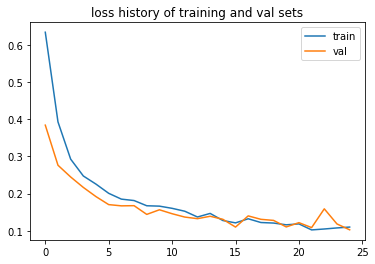

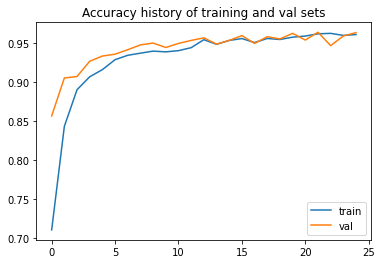

In [97]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
# conv layers: (in_channels, out_channels, kernel_size, stride, padding)
conv_layers = [(3, 32, 11, 3), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_type='dropout', dropout_rate=0.4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/Conv1')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

: Test Loss: 1.210e-01: : 71it [00:03, 22.09it/s]

Accuracy of Test set: 0.9606666666666667


{'loss': 0.12099685246414608,
 'accuracy': 0.9606666666666667,
 'precision': 0.9611376960301521,
 'recall': 0.9605166538980248,
 'f1': 0.9604617346169407}

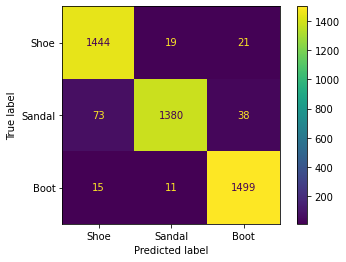

In [40]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.target_names)
disp.plot()
test_results

In [41]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 149443


Tensorboard results:

![Conv1-tensorboard](Images/Conv1-tensorboard.png)

As expected, we achieved a much better result, with significantly less number of parameters compared to MLP model.

# Block Dropout

0: Train Loss: 8.638e-01: : 132it [00:07, 18.64it/s]


Accuracy of Train set: 0.5766666666666667


0: Validation Loss: 6.018e-01: : 33it [00:01, 21.60it/s]


Accuracy of Validation set: 0.7376190476190476

 ------------------------------------------------------------


1: Train Loss: 6.226e-01: : 132it [00:07, 17.15it/s]


Accuracy of Train set: 0.7198809523809524


1: Validation Loss: 5.279e-01: : 33it [00:01, 22.11it/s]


Accuracy of Validation set: 0.7666666666666667

 ------------------------------------------------------------


2: Train Loss: 5.460e-01: : 132it [00:07, 18.81it/s]


Accuracy of Train set: 0.7691666666666667


2: Validation Loss: 4.225e-01: : 33it [00:01, 21.72it/s]


Accuracy of Validation set: 0.8252380952380952

 ------------------------------------------------------------


3: Train Loss: 5.058e-01: : 132it [00:07, 18.61it/s]


Accuracy of Train set: 0.8021428571428572


3: Validation Loss: 3.472e-01: : 33it [00:01, 21.72it/s]


Accuracy of Validation set: 0.8690476190476191

 ------------------------------------------------------------


4: Train Loss: 4.459e-01: : 132it [00:07, 18.76it/s]


Accuracy of Train set: 0.8202380952380952


4: Validation Loss: 3.174e-01: : 33it [00:01, 21.85it/s]


Accuracy of Validation set: 0.8947619047619048

 ------------------------------------------------------------


5: Train Loss: 3.901e-01: : 132it [00:07, 18.68it/s]


Accuracy of Train set: 0.8457142857142858


5: Validation Loss: 2.839e-01: : 33it [00:01, 21.62it/s]


Accuracy of Validation set: 0.9095238095238095

 ------------------------------------------------------------


6: Train Loss: 3.351e-01: : 132it [00:07, 18.84it/s]


Accuracy of Train set: 0.8701190476190476


6: Validation Loss: 2.588e-01: : 33it [00:01, 21.47it/s]


Accuracy of Validation set: 0.9047619047619048

 ------------------------------------------------------------


7: Train Loss: 3.046e-01: : 132it [00:06, 18.94it/s]


Accuracy of Train set: 0.881547619047619


7: Validation Loss: 2.330e-01: : 33it [00:01, 21.69it/s]


Accuracy of Validation set: 0.9195238095238095

 ------------------------------------------------------------


8: Train Loss: 2.935e-01: : 132it [00:06, 18.96it/s]


Accuracy of Train set: 0.8896428571428572


8: Validation Loss: 2.236e-01: : 33it [00:01, 21.77it/s]


Accuracy of Validation set: 0.9242857142857143

 ------------------------------------------------------------


9: Train Loss: 2.813e-01: : 132it [00:06, 18.87it/s]


Accuracy of Train set: 0.8980952380952381


9: Validation Loss: 2.050e-01: : 33it [00:01, 22.04it/s]


Accuracy of Validation set: 0.9285714285714286

 ------------------------------------------------------------


10: Train Loss: 2.715e-01: : 132it [00:07, 18.58it/s]


Accuracy of Train set: 0.8998809523809523


10: Validation Loss: 1.831e-01: : 33it [00:01, 21.84it/s]


Accuracy of Validation set: 0.9347619047619048

 ------------------------------------------------------------


11: Train Loss: 2.466e-01: : 132it [00:07, 18.55it/s]


Accuracy of Train set: 0.9098809523809523


11: Validation Loss: 2.016e-01: : 33it [00:01, 22.18it/s]


Accuracy of Validation set: 0.9233333333333333

 ------------------------------------------------------------


12: Train Loss: 2.433e-01: : 132it [00:06, 18.91it/s]


Accuracy of Train set: 0.9089285714285714


12: Validation Loss: 1.773e-01: : 33it [00:01, 21.37it/s]


Accuracy of Validation set: 0.94

 ------------------------------------------------------------


13: Train Loss: 2.173e-01: : 132it [00:06, 18.88it/s]


Accuracy of Train set: 0.9198809523809524


13: Validation Loss: 1.844e-01: : 33it [00:01, 22.22it/s]


Accuracy of Validation set: 0.9347619047619048

 ------------------------------------------------------------


14: Train Loss: 2.019e-01: : 132it [00:07, 18.77it/s]


Accuracy of Train set: 0.9282142857142858


14: Validation Loss: 1.574e-01: : 33it [00:02, 16.07it/s]


Accuracy of Validation set: 0.9452380952380952

 ------------------------------------------------------------


15: Train Loss: 1.885e-01: : 132it [00:07, 18.85it/s]


Accuracy of Train set: 0.9295238095238095


15: Validation Loss: 1.726e-01: : 33it [00:01, 21.89it/s]


Accuracy of Validation set: 0.9361904761904762

 ------------------------------------------------------------


16: Train Loss: 2.022e-01: : 132it [00:07, 18.84it/s]


Accuracy of Train set: 0.9263095238095238


16: Validation Loss: 1.559e-01: : 33it [00:01, 22.36it/s]


Accuracy of Validation set: 0.9495238095238095

 ------------------------------------------------------------


17: Train Loss: 1.900e-01: : 132it [00:07, 18.76it/s]


Accuracy of Train set: 0.9291666666666667


17: Validation Loss: 1.583e-01: : 33it [00:01, 22.41it/s]


Accuracy of Validation set: 0.9471428571428572

 ------------------------------------------------------------


18: Train Loss: 1.852e-01: : 132it [00:07, 18.79it/s]


Accuracy of Train set: 0.9325


18: Validation Loss: 1.359e-01: : 33it [00:01, 22.11it/s]


Accuracy of Validation set: 0.9523809523809523

 ------------------------------------------------------------


19: Train Loss: 1.808e-01: : 132it [00:07, 18.82it/s]


Accuracy of Train set: 0.9322619047619047


19: Validation Loss: 1.473e-01: : 33it [00:01, 21.45it/s]


Accuracy of Validation set: 0.9504761904761905

 ------------------------------------------------------------


20: Train Loss: 1.801e-01: : 132it [00:06, 19.00it/s]


Accuracy of Train set: 0.9326190476190476


20: Validation Loss: 1.396e-01: : 33it [00:01, 22.26it/s]


Accuracy of Validation set: 0.9476190476190476

 ------------------------------------------------------------


21: Train Loss: 1.657e-01: : 132it [00:06, 18.90it/s]


Accuracy of Train set: 0.9384523809523809


21: Validation Loss: 1.374e-01: : 33it [00:01, 22.20it/s]


Accuracy of Validation set: 0.949047619047619

 ------------------------------------------------------------


22: Train Loss: 1.767e-01: : 132it [00:07, 18.75it/s]


Accuracy of Train set: 0.9353571428571429


22: Validation Loss: 1.411e-01: : 33it [00:01, 21.68it/s]


Accuracy of Validation set: 0.9480952380952381

 ------------------------------------------------------------


23: Train Loss: 1.627e-01: : 132it [00:06, 18.92it/s]


Accuracy of Train set: 0.9396428571428571


23: Validation Loss: 1.409e-01: : 33it [00:01, 21.73it/s]


Accuracy of Validation set: 0.9523809523809523

 ------------------------------------------------------------


24: Train Loss: 1.580e-01: : 132it [00:07, 17.30it/s]


Accuracy of Train set: 0.9438095238095238


24: Validation Loss: 1.188e-01: : 33it [00:01, 21.74it/s]


Accuracy of Validation set: 0.96

 ------------------------------------------------------------


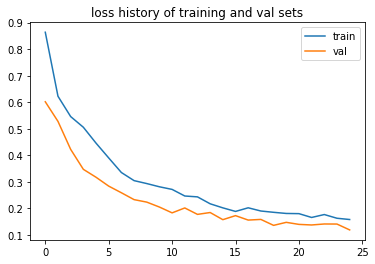

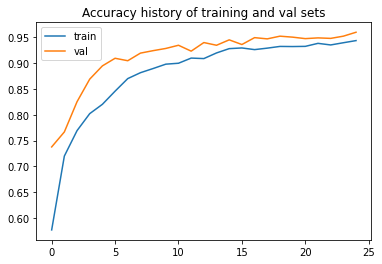

In [63]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
conv_layers = [(3, 32, 11, 3), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_type='block', dropout_rate=0.4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/Conv2')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

: Test Loss: 1.244e-01: : 71it [00:03, 22.20it/s]


Accuracy of Test set: 0.9542222222222222


{'loss': 0.12436343572205967,
 'accuracy': 0.9542222222222222,
 'precision': 0.9543783606748679,
 'recall': 0.9540862178259092,
 'f1': 0.9540394285914457}

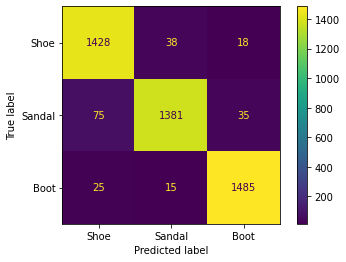

In [64]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.target_names)
disp.plot()
test_results

In [65]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 149443


Tensorboard Results:

![Conv2-tensorboard](Images/Conv2-tensorboard.png)

# Kernel Factorization

0: Train Loss: 6.857e-01: : 132it [00:10, 12.37it/s]


Accuracy of Train set: 0.6839285714285714


0: Validation Loss: 4.507e-01: : 33it [00:01, 19.77it/s]


Accuracy of Validation set: 0.8219047619047619

 ------------------------------------------------------------


1: Train Loss: 4.593e-01: : 132it [00:10, 12.55it/s]


Accuracy of Train set: 0.8154761904761905


1: Validation Loss: 3.648e-01: : 33it [00:01, 19.95it/s]


Accuracy of Validation set: 0.8685714285714285

 ------------------------------------------------------------


2: Train Loss: 3.959e-01: : 132it [00:10, 12.50it/s]


Accuracy of Train set: 0.8483333333333334


2: Validation Loss: 2.881e-01: : 33it [00:01, 19.65it/s]


Accuracy of Validation set: 0.8985714285714286

 ------------------------------------------------------------


3: Train Loss: 3.307e-01: : 132it [00:10, 12.66it/s]


Accuracy of Train set: 0.8807142857142857


3: Validation Loss: 3.751e-01: : 33it [00:01, 19.79it/s]


Accuracy of Validation set: 0.8857142857142857

 ------------------------------------------------------------


4: Train Loss: 2.841e-01: : 132it [00:10, 12.70it/s]


Accuracy of Train set: 0.8980952380952381


4: Validation Loss: 2.357e-01: : 33it [00:01, 19.88it/s]


Accuracy of Validation set: 0.9238095238095239

 ------------------------------------------------------------


5: Train Loss: 2.358e-01: : 132it [00:11, 11.53it/s]


Accuracy of Train set: 0.915


5: Validation Loss: 2.114e-01: : 33it [00:01, 19.96it/s]


Accuracy of Validation set: 0.9228571428571428

 ------------------------------------------------------------


6: Train Loss: 2.288e-01: : 132it [00:10, 12.62it/s]


Accuracy of Train set: 0.9171428571428571


6: Validation Loss: 1.833e-01: : 33it [00:01, 19.81it/s]


Accuracy of Validation set: 0.9414285714285714

 ------------------------------------------------------------


7: Train Loss: 2.012e-01: : 132it [00:10, 12.62it/s]


Accuracy of Train set: 0.9278571428571428


7: Validation Loss: 2.213e-01: : 33it [00:01, 19.76it/s]


Accuracy of Validation set: 0.9195238095238095

 ------------------------------------------------------------


8: Train Loss: 1.989e-01: : 132it [00:10, 12.03it/s]


Accuracy of Train set: 0.9254761904761905


8: Validation Loss: 1.794e-01: : 33it [00:01, 18.79it/s]


Accuracy of Validation set: 0.9385714285714286

 ------------------------------------------------------------


9: Train Loss: 1.798e-01: : 132it [00:10, 12.55it/s]


Accuracy of Train set: 0.934404761904762


9: Validation Loss: 1.557e-01: : 33it [00:01, 19.23it/s]


Accuracy of Validation set: 0.9438095238095238

 ------------------------------------------------------------


10: Train Loss: 1.990e-01: : 132it [00:10, 12.60it/s]


Accuracy of Train set: 0.9269047619047619


10: Validation Loss: 2.497e-01: : 33it [00:01, 19.90it/s]


Accuracy of Validation set: 0.9204761904761904

 ------------------------------------------------------------


11: Train Loss: 1.878e-01: : 132it [00:10, 12.49it/s]


Accuracy of Train set: 0.9332142857142857


11: Validation Loss: 1.460e-01: : 33it [00:01, 19.86it/s]


Accuracy of Validation set: 0.950952380952381

 ------------------------------------------------------------


12: Train Loss: 1.731e-01: : 132it [00:10, 12.59it/s]


Accuracy of Train set: 0.9370238095238095


12: Validation Loss: 1.613e-01: : 33it [00:01, 19.03it/s]


Accuracy of Validation set: 0.9461904761904761

 ------------------------------------------------------------


13: Train Loss: 1.489e-01: : 132it [00:10, 12.40it/s]


Accuracy of Train set: 0.9472619047619047


13: Validation Loss: 1.718e-01: : 33it [00:01, 19.55it/s]


Accuracy of Validation set: 0.9395238095238095

 ------------------------------------------------------------


14: Train Loss: 1.319e-01: : 132it [00:10, 12.58it/s]


Accuracy of Train set: 0.9529761904761904


14: Validation Loss: 1.470e-01: : 33it [00:01, 19.16it/s]


Accuracy of Validation set: 0.9566666666666667

 ------------------------------------------------------------


15: Train Loss: 1.293e-01: : 132it [00:10, 12.53it/s]


Accuracy of Train set: 0.9532142857142857


15: Validation Loss: 1.769e-01: : 33it [00:01, 19.81it/s]


Accuracy of Validation set: 0.9466666666666667

 ------------------------------------------------------------


16: Train Loss: 1.374e-01: : 132it [00:10, 12.63it/s]


Accuracy of Train set: 0.9529761904761904


16: Validation Loss: 1.451e-01: : 33it [00:01, 19.83it/s]


Accuracy of Validation set: 0.9528571428571428

 ------------------------------------------------------------


17: Train Loss: 1.149e-01: : 132it [00:10, 12.52it/s]


Accuracy of Train set: 0.9586904761904762


17: Validation Loss: 1.496e-01: : 33it [00:01, 19.33it/s]


Accuracy of Validation set: 0.9538095238095238

 ------------------------------------------------------------


18: Train Loss: 1.154e-01: : 132it [00:10, 12.61it/s]


Accuracy of Train set: 0.9591666666666666


18: Validation Loss: 1.483e-01: : 33it [00:01, 19.52it/s]


Accuracy of Validation set: 0.9580952380952381

 ------------------------------------------------------------


19: Train Loss: 1.051e-01: : 132it [00:10, 12.52it/s]


Accuracy of Train set: 0.9629761904761904


19: Validation Loss: 1.421e-01: : 33it [00:01, 19.71it/s]


Accuracy of Validation set: 0.9561904761904761

 ------------------------------------------------------------


20: Train Loss: 1.171e-01: : 132it [00:10, 12.47it/s]


Accuracy of Train set: 0.9567857142857142


20: Validation Loss: 1.492e-01: : 33it [00:01, 19.74it/s]


Accuracy of Validation set: 0.9519047619047619

 ------------------------------------------------------------


21: Train Loss: 1.073e-01: : 132it [00:10, 12.45it/s]


Accuracy of Train set: 0.9613095238095238


21: Validation Loss: 1.554e-01: : 33it [00:01, 19.24it/s]


Accuracy of Validation set: 0.9571428571428572

 ------------------------------------------------------------


22: Train Loss: 1.162e-01: : 132it [00:10, 12.28it/s]


Accuracy of Train set: 0.9575


22: Validation Loss: 1.407e-01: : 33it [00:01, 18.82it/s]


Accuracy of Validation set: 0.9604761904761905

 ------------------------------------------------------------


23: Train Loss: 9.234e-02: : 132it [00:10, 12.45it/s]


Accuracy of Train set: 0.9670238095238095


23: Validation Loss: 1.615e-01: : 33it [00:01, 19.39it/s]


Accuracy of Validation set: 0.9585714285714285

 ------------------------------------------------------------


24: Train Loss: 1.070e-01: : 132it [00:10, 12.54it/s]


Accuracy of Train set: 0.9617857142857142


24: Validation Loss: 1.881e-01: : 33it [00:01, 19.08it/s]


Accuracy of Validation set: 0.9476190476190476

 ------------------------------------------------------------


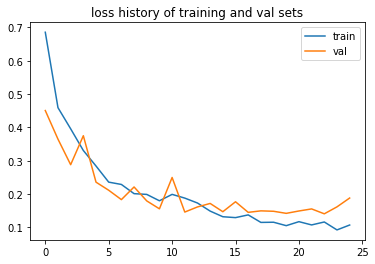

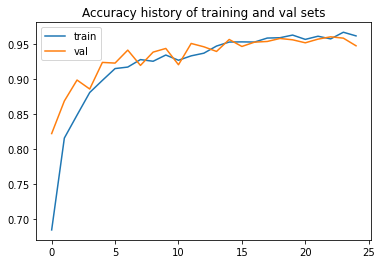

In [78]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
conv_layers = [(3, 32, 11), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_type='block', dropout_rate=0.4, kernel_factorization=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/Conv3')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

: Test Loss: 1.569e-01: : 71it [00:04, 17.74it/s]


Accuracy of Test set: 0.9528888888888889


{'loss': 0.15688251818550958,
 'accuracy': 0.9528888888888889,
 'precision': 0.9531167185805703,
 'recall': 0.9529011723708578,
 'f1': 0.9528737654960168}

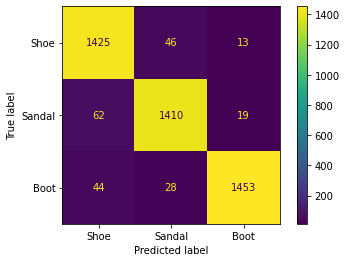

In [80]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.target_names)
disp.plot()
test_results

In [81]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 381411


Note: the reason behind its higher number of parameters than simple convolutional model is that they had a stride of 3 in their first conv layer, which reduced the number of parameters significantly.  
But we can't use stride in this model as simply as that, and I didn't used it in this model.  
If simple convolutional model had a stride of 3 in its first conv layer, it would have had 425539 parameters:

In [22]:
device = 'cpu'
conv_layers = [(3, 32, 11), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_rate=0.4, kernel_factorization=False).to(device)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 425539


This approach can be used to reduce the number of parameters in this model, for using in devices with limited processing power, such as mobile phones, and still achieve good results.

Tensorboard Results:

![Conv3-tensorboard](Images/Conv3-tensorboard.png)

In [ ]:
!zip -r runs.zip runs